In [729]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import sklearn
from sklearn.datasets import make_circles

# Data

In [730]:
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)
X.shape, y.shape

((1000, 2), (1000,))

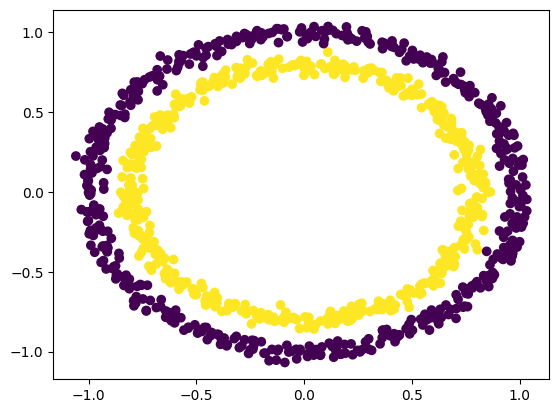

In [731]:
plt.scatter(X[:,0], X[:,1], c=y)

In [732]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [733]:
X = torch.from_numpy(X).to(torch.float).to(device)
Y = torch.from_numpy(y).to(torch.float).to(device)

In [734]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = torch.from_numpy(y_train).to(torch.float).to(device)
y_test = torch.from_numpy(y_test).to(torch.float).to(device)
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

# Build Model

In [735]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=20)
        self.layer_2 = nn.Linear(in_features=20, out_features=20)
        self.layer_3 = nn.Linear(in_features=20, out_features=20)
        self.layer_4 = nn.Linear(in_features=20, out_features=1)
        self.relu = nn.ReLU()
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

model = CircleModel().to(device)
model

CircleModel(
  (layer_1): Linear(in_features=2, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=20, bias=True)
  (layer_4): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)

In [736]:
with torch.inference_mode():
    untrained_preds = model(X_test)
untrained_preds.shape, y_test.shape

(torch.Size([200, 1]), torch.Size([200]))

# Train

In [737]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [738]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [739]:
epochs = 1000

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    # acc = accuracy_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.inference_mode():
        y_test_logits = model(X_test).squeeze()
        y_test_pred = torch.round(torch.sigmoid(y_test_logits))
        test_loss = loss_fn(y_test_logits, y_test)
        # test_acc = accuracy_fn(y_test_pred, y_test)
        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
    
    # if epoch % 10 == 0:
        # print(f'epoch: {epoch}, loss: {loss:.2f}, test_loss: {test_loss:.2f}, acc: {acc:.2f}, test_acc: {test_acc:.2f}')

In [740]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

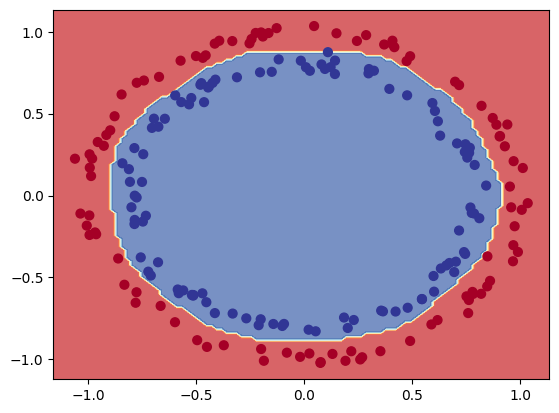

In [741]:
plot_decision_boundary(model, X_test, y_test)

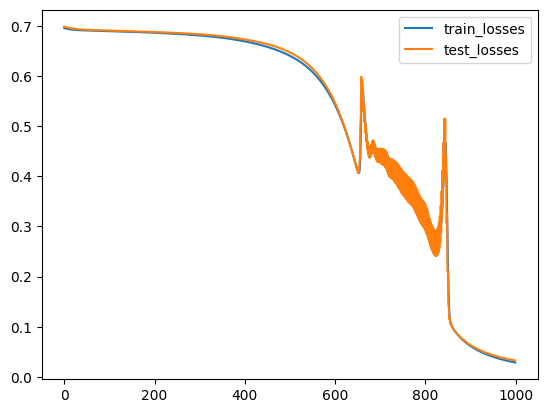

In [742]:
plt.plot(range(epochs), train_losses, label='train_losses')
plt.plot(range(epochs), test_losses, label='test_losses')
plt.legend()

# Multi Class Classification

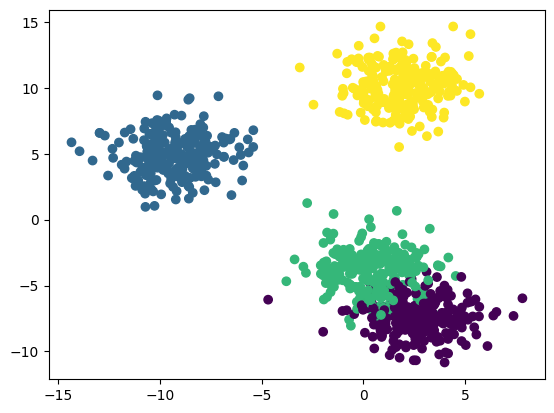

In [743]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X, y = make_blobs(n_samples=1000,
                  n_features=2,
                  centers=4,
                  cluster_std=1.5
)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2
                                                    )

plt.scatter(X[:,0],X[:,1], c=y)

# build model

In [744]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )
        
    def forward(self,x):
        return self.linear_layer_stack(x)
    
model = BlobModel(input_features=2,
                  output_features=4,
                  hidden_units=8).to(device)
model


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [745]:
## Untrained pred

model.eval()
with torch.inference_mode():
    y_logits = model(X_test)
    
y_test_pred = torch.softmax(y_logits, dim=1)
    
y_logits[:10]

tensor([[ 0.5667,  0.0107, -0.3610, -0.6293],
        [-0.0098,  0.3510,  0.1495, -0.2662],
        [ 0.8087, -0.4649, -0.4681, -0.3803],
        [-0.4220,  0.3007,  0.9745, -0.1870],
        [ 0.6878, -0.1221, -0.3779, -0.8007],
        [ 0.6736, -0.1065, -0.3759, -0.7806],
        [-0.2834,  0.3258,  0.6784, -0.2231],
        [ 0.6530, -0.0840, -0.3731, -0.7515],
        [-0.0274,  0.3363,  0.2135, -0.2483],
        [ 0.4485,  0.1279, -0.0824, -0.0013]])

In [746]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

In [747]:
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()
    
    y_logits = model(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    loss = loss_fn(y_logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.inference_mode():
        y_test_logits = model(X_test)
        y_test_preds = torch.softmax(y_test_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(y_test_logits, y_test)
        # test_acc = accuracy_fn(y_true=y_test_pred,
        #                        y_pred=y_test_pred)
        
    if epoch % 10 == 0:
        print(f"epoch {epoch} loss {loss:.2f}")

epoch 0 loss 1.62
epoch 10 loss 0.75
epoch 20 loss 0.62
epoch 30 loss 0.55
epoch 40 loss 0.50
epoch 50 loss 0.42
epoch 60 loss 0.34
epoch 70 loss 0.29
epoch 80 loss 0.26
epoch 90 loss 0.24
epoch 100 loss 0.23
epoch 110 loss 0.21
epoch 120 loss 0.20
epoch 130 loss 0.19
epoch 140 loss 0.20
epoch 150 loss 0.20
epoch 160 loss 0.18
epoch 170 loss 0.17
epoch 180 loss 0.16
epoch 190 loss 0.16
epoch 200 loss 0.15
epoch 210 loss 0.15
epoch 220 loss 0.14
epoch 230 loss 0.14
epoch 240 loss 0.13
epoch 250 loss 0.13
epoch 260 loss 0.13
epoch 270 loss 0.12
epoch 280 loss 0.12
epoch 290 loss 0.12
epoch 300 loss 0.12
epoch 310 loss 0.11
epoch 320 loss 0.11
epoch 330 loss 0.11
epoch 340 loss 0.11
epoch 350 loss 0.11
epoch 360 loss 0.10
epoch 370 loss 0.10
epoch 380 loss 0.10
epoch 390 loss 0.10
epoch 400 loss 0.10
epoch 410 loss 0.10
epoch 420 loss 0.10
epoch 430 loss 0.10
epoch 440 loss 0.10
epoch 450 loss 0.10
epoch 460 loss 0.09
epoch 470 loss 0.09
epoch 480 loss 0.09
epoch 490 loss 0.09
epoch 500 l

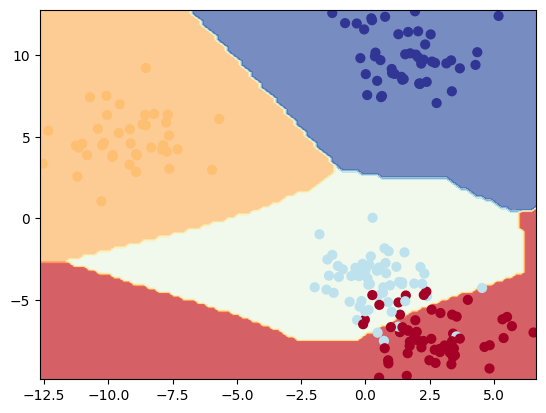

In [748]:
plot_decision_boundary(model, X_test, y_test)

<Axes: >

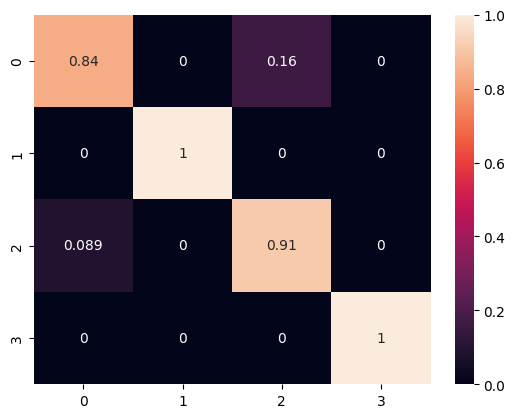

In [755]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

cf_matrix = confusion_matrix(y_test, y_test_preds)

classes = list(range(4))
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
sn.heatmap(df_cm, annot=True)